# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-I,ambiguous,7550,82161
1,BX-I,no-author-rec,13734,22808
2,BX-I,female,69239,397555
3,BX-I,no-book,44068,62530
4,BX-I,unknown,31406,70351


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,226613.0,503440.0,19084.0,219529.0,137536.0,151529.0,1010096.0,2267827.0
BX-E,39245.0,56959.0,4431.0,15256.0,6739.0,6548.0,21884.0,151062.0
BX-I,69239.0,99213.0,7550.0,31406.0,13734.0,13047.0,44068.0,278257.0
GR-E,182866.0,284112.0,12591.0,85017.0,28899.0,894574.0,NaN,1488059.0
GR-I,184586.0,287589.0,12709.0,86596.0,29597.0,908584.0,NaN,1509661.0
LOC-MDS,704588.0,2307220.0,60945.0,1085722.0,266671.0,842797.0,NaN,5267943.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4464070.0,6680448.0,586430.0,1859540.0,695530.0,2076437.0,6096946.0
BX-E,141022.0,184988.0,32703.0,24831.0,8589.0,9505.0,25524.0
BX-I,397555.0,467936.0,82161.0,70351.0,22808.0,25905.0,62530.0
GR-E,35499436.0,34646593.0,9531767.0,3324420.0,476053.0,16923705.0,NaN
GR-I,78217847.0,71049268.0,15504674.0,8740673.0,1334059.0,46650160.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.099925,0.221992,0.008415,0.096801,0.060647,0.066817,0.445403
BX-E,0.259794,0.377057,0.029332,0.100992,0.044611,0.043346,0.144868
BX-I,0.248831,0.356552,0.027133,0.112867,0.049357,0.046888,0.158372
GR-E,0.122889,0.190928,0.008461,0.057133,0.019421,0.601168,NaN
GR-I,0.122270,0.190499,0.008418,0.057361,0.019605,0.601846,NaN
LOC-MDS,0.133750,0.437974,0.011569,0.206100,0.050621,0.159986,NaN


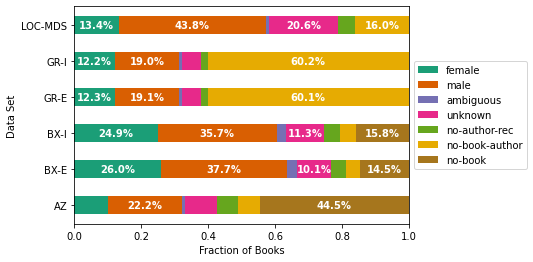

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.099925,0.221992,0.008415,0.096801,0.572866
BX-E,0.259794,0.377057,0.029332,0.100992,0.232825
BX-I,0.248831,0.356552,0.027133,0.112867,0.254617
GR-E,0.122889,0.190928,0.008461,0.057133,0.620589
GR-I,0.122270,0.190499,0.008418,0.057361,0.621451
LOC-MDS,0.133750,0.437974,0.011569,0.206100,0.210607


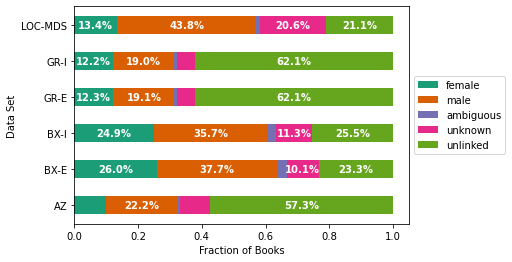

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

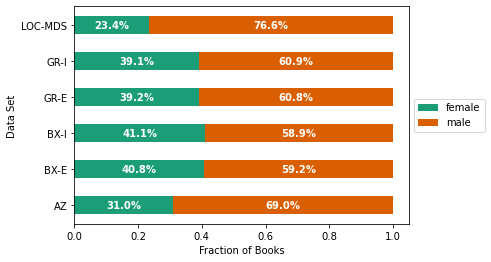

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.198762,0.297446,0.026111,0.082796,0.030968,0.092453,0.271465
BX-E,0.330137,0.433063,0.076559,0.058130,0.020107,0.022252,0.059753
BX-I,0.352053,0.414379,0.072757,0.062299,0.020198,0.022940,0.055373
GR-E,0.353573,0.345079,0.094936,0.033111,0.004741,0.168559,NaN
GR-I,0.353133,0.320769,0.070000,0.039462,0.006023,0.210613,NaN


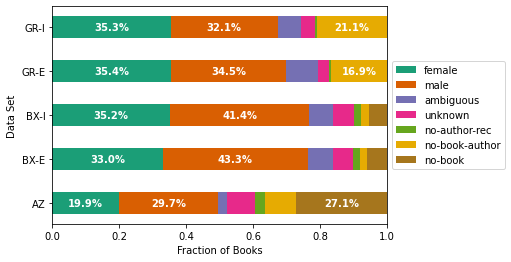

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.198762,0.297446,0.026111,0.082796,0.394886
BX-E,0.330137,0.433063,0.076559,0.058130,0.102111
BX-I,0.352053,0.414379,0.072757,0.062299,0.098511
GR-E,0.353573,0.345079,0.094936,0.033111,0.173301
GR-I,0.353133,0.320769,0.070000,0.039462,0.216636


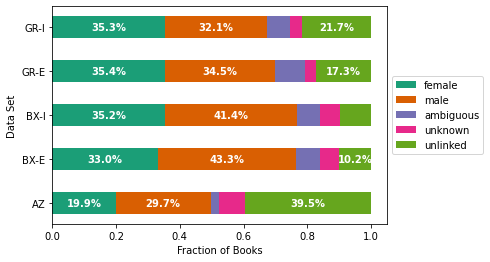

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

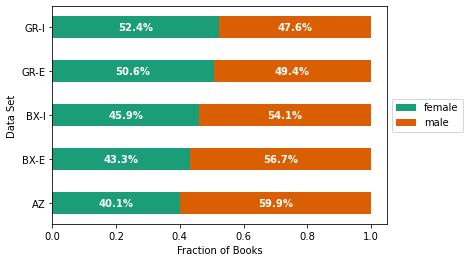

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.330333
BX-E       0.666183
BX-I       0.632516
GR-E       0.322278
GR-I       0.321187
LOC-MDS    0.583293
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')